In [1]:
pip install -U scikit-learn==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.5 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
import pickle

In [8]:
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=8)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(kernel_size=4, padding=2)
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=8)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=4, padding=2)
        self.dropout2 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(128, 64, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [9]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=8, dropout_rate=0.3):
        super(EmotionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        if lstm_out.size(1) == 1:
            lstm_out = lstm_out.squeeze(1)
        else:
            lstm_out = lstm_out[:, -1, :]
        
        lstm_out = self.bn(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [10]:
NUM_EMOTIONS = 8 
EMOTION_LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

class VotingEnsemble(nn.Module):
    def __init__(self, speech_model, facial_model):
        super(VotingEnsemble, self).__init__()
        self.speech_model = speech_model
        self.facial_model = facial_model
        
        for param in self.speech_model.parameters():
            param.requires_grad = False
        for param in self.facial_model.parameters():
            param.requires_grad = False
            
        self.speech_weight = nn.Parameter(torch.tensor(0.5))
        self.facial_weight = nn.Parameter(torch.tensor(0.5))
        
    def forward(self, speech_input, facial_input):
        speech_out = self.speech_model(speech_input)
        facial_out = self.facial_model(facial_input)
        
        speech_probs = torch.softmax(speech_out, dim=1) * torch.sigmoid(self.speech_weight)
        facial_probs = torch.softmax(facial_out, dim=1) * torch.sigmoid(self.facial_weight)
        weighted_avg = (speech_probs + facial_probs) / (torch.sigmoid(self.speech_weight) + torch.sigmoid(self.facial_weight))
        
        return weighted_avg  

In [11]:
def evaluate_model(model, speech_data, facial_data, labels, device='cuda'):
    model.eval()
    
    speech_data = speech_data.to(device)
    facial_data = facial_data.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(speech_data, facial_data)
        _, predicted = torch.max(outputs, 1)
        
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        acc = accuracy_score(labels_np, predicted_np)
        report = classification_report(labels_np, predicted_np, target_names=EMOTION_LABELS, output_dict=True)
        conf_matrix = confusion_matrix(labels_np, predicted_np)
        
        per_class_acc = report['weighted avg']['precision']
        
        return {
            'accuracy': acc,
            'per_class_accuracy': per_class_acc,
            'classification_report': report,
            'confusion_matrix': conf_matrix
        }

def visualize_confusion_matrix(conf_matrix, class_names=EMOTION_LABELS):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def evaluate_individual_vs_ensemble(speech_model, facial_model, ensemble_model, 
                                   speech_data, facial_data, labels, device='cuda'):
    speech_data = speech_data.to(device)
    facial_data = facial_data.to(device)
    labels = labels.to(device)
    
    speech_model.eval()
    facial_model.eval()
    ensemble_model.eval()
    
    with torch.no_grad():
        speech_outputs = speech_model(speech_data)
        facial_outputs = facial_model(facial_data)
        ensemble_outputs = ensemble_model(speech_data, facial_data)
        
        _, speech_preds = torch.max(speech_outputs, 1)
        _, facial_preds = torch.max(facial_outputs, 1)
        _, ensemble_preds = torch.max(ensemble_outputs, 1)
        
        speech_preds_np = speech_preds.cpu().numpy()
        facial_preds_np = facial_preds.cpu().numpy()
        ensemble_preds_np = ensemble_preds.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        speech_acc = accuracy_score(labels_np, speech_preds_np)
        facial_acc = accuracy_score(labels_np, facial_preds_np)
        ensemble_acc = accuracy_score(labels_np, ensemble_preds_np)
        
        speech_report = classification_report(labels_np, speech_preds_np, 
                                             target_names=EMOTION_LABELS, output_dict=True)
        facial_report = classification_report(labels_np, facial_preds_np, 
                                             target_names=EMOTION_LABELS, output_dict=True)
        ensemble_report = classification_report(labels_np, ensemble_preds_np, 
                                              target_names=EMOTION_LABELS, output_dict=True)
        
        speech_cm = confusion_matrix(labels_np, speech_preds_np)
        facial_cm = confusion_matrix(labels_np, facial_preds_np)
        ensemble_cm = confusion_matrix(labels_np, ensemble_preds_np)
        
        return {
            'speech': {
                'accuracy': speech_acc,
                'classification_report': speech_report,
                'confusion_matrix': speech_cm
            },
            'facial': {
                'accuracy': facial_acc,
                'classification_report': facial_report,
                'confusion_matrix': facial_cm
            },
            'ensemble': {
                'accuracy': ensemble_acc,
                'classification_report': ensemble_report,
                'confusion_matrix': ensemble_cm
            }
        }

def plot_comparison(results):
    models = ['Speech Model', 'Facial Model', 'Ensemble Model']
    accuracies = [
        results['speech']['accuracy'] * 100,
        results['facial']['accuracy'] * 100,
        results['ensemble']['accuracy'] * 100
    ]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'green', 'red'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.ylabel('Accuracy (%)')
    plt.title('Model Comparison')
    plt.ylim(0, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

Speech Model Accuracy: 0.9825
Facial Model Accuracy: 0.9123
Ensemble Model Accuracy: 0.9474


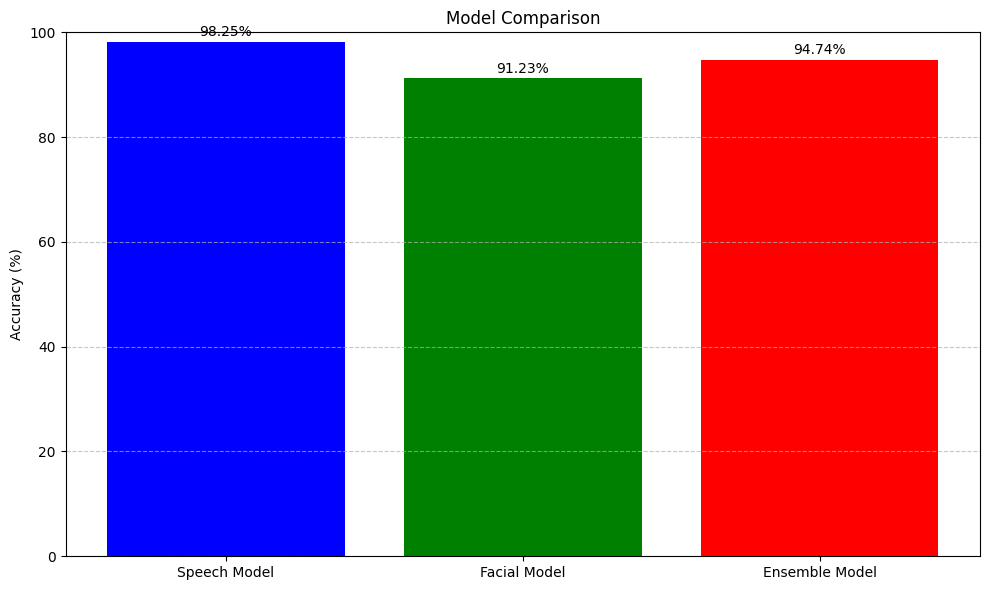

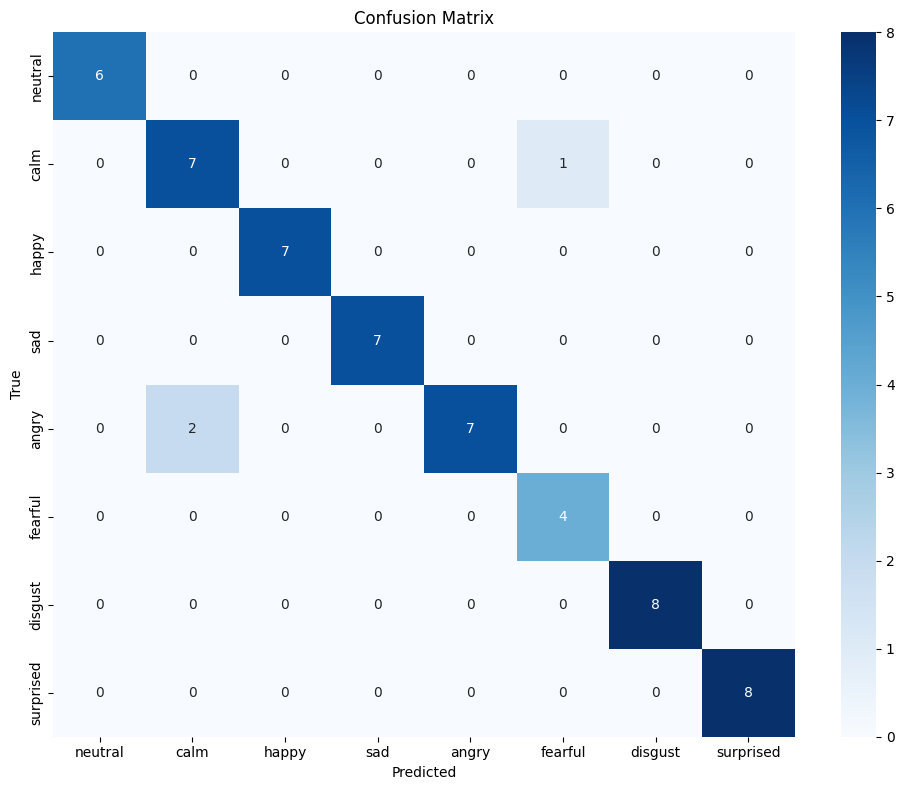


Ensemble Classification Report:
neutral: precision=1.00, recall=1.00, f1-score=1.00
calm: precision=0.78, recall=0.88, f1-score=0.82
happy: precision=1.00, recall=1.00, f1-score=1.00
sad: precision=1.00, recall=1.00, f1-score=1.00
angry: precision=1.00, recall=0.78, f1-score=0.88
fearful: precision=0.80, recall=1.00, f1-score=0.89
disgust: precision=1.00, recall=1.00, f1-score=1.00
surprised: precision=1.00, recall=1.00, f1-score=1.00
macro avg: precision=0.95, recall=0.96, f1-score=0.95
weighted avg: precision=0.95, recall=0.95, f1-score=0.95


In [12]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    df_speech = pd.read_csv("C:/Nini/Capstone/CSV_Files/Speech data/Speech_Test1_preprocessed_new.csv")
    X_speech = df_speech.drop(columns=['Path','Unnamed: 0','Emotion']).values 
    X_tensor_speech = torch.tensor(X_speech, dtype=torch.float32).unsqueeze(1)
    torch.save(X_tensor_speech, "C:/Nini/Capstone/CSV_Files/Speech data/speech_test_data.pt")
    speech_test_data = torch.load("C:/Nini/Capstone/CSV_Files/Speech data/speech_test_data.pt", weights_only=True)

    df_face = pd.read_excel("C:/Nini/Capstone/CSV_Files/Facial data/New Facial Data/FaceTest(e)(arranged).xlsx")
    X_face = df_face.drop(columns=['video_path','emotion']).values
    scaler = RobustScaler()
    X_face_scaled = scaler.fit_transform(X_face)
    X_tensor_face = torch.tensor(X_face_scaled, dtype=torch.float32).reshape((X_face_scaled.shape[0], 1, X_face_scaled.shape[1]))
    torch.save(X_tensor_face, 'C:/Nini/Capstone/CSV_Files/Facial data/New Facial Data/face_test_data.pt')
    facial_test_data = torch.load('C:/Nini/Capstone/CSV_Files/Facial data/New Facial Data/face_test_data.pt', weights_only=True)

    with open("C:/Nini/Capstone/src/Model_training/label_encoder.pkl", 'rb') as f:
        label_encoder = pickle.load(f)
    test_labels = df_speech['Emotion'].values
    test_labels_encoded = label_encoder.transform(test_labels)
    test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)
    torch.save(test_labels_tensor, "C:/Nini/Capstone/CSV_Files/Speech data/test_labels.pt")
    test_labels = torch.load('C:/Nini/Capstone/CSV_Files/Speech data/test_labels.pt', weights_only=True)
    
    speech_model = CNNModel(input_size=X_speech.shape[1], num_classes=8).to(device)
    facial_model = EmotionLSTM(input_size=X_face.shape[1]).to(device)
    
    speech_model.load_state_dict(torch.load("C:/Nini/Capstone/Models/DataAugmentation_cnn_model_new_final_1.pth", weights_only=True))
    facial_model.load_state_dict(torch.load("C:/Nini/Capstone/Models/emotion_lstm_model-7.pth", weights_only=True))
    
    ensemble_model = VotingEnsemble(speech_model, facial_model).to(device)
    
    results = evaluate_individual_vs_ensemble(
        speech_model, facial_model, ensemble_model,
        speech_test_data, facial_test_data, test_labels, device
    )

    print(f"Speech Model Accuracy: {results['speech']['accuracy']:.4f}")
    print(f"Facial Model Accuracy: {results['facial']['accuracy']:.4f}")
    print(f"Ensemble Model Accuracy: {results['ensemble']['accuracy']:.4f}")

    plot_comparison(results)
    
    visualize_confusion_matrix(results['ensemble']['confusion_matrix'])
    
    print("\nEnsemble Classification Report:")
    for emotion, metrics in results['ensemble']['classification_report'].items():
        if isinstance(metrics, dict):
            print(f"{emotion}: precision={metrics['precision']:.2f}, recall={metrics['recall']:.2f}, f1-score={metrics['f1-score']:.2f}")

if __name__ == "__main__":
    main()